In [1]:
#Importing mnist using keras and reshaping and using first 1000 examples for train and test  
import numpy as np
from keras.datasets import mnist
import pandas as pd
%matplotlib inline 

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train= X_train/255
X_test = X_test/255
temp=X_train.reshape(60000,28*28).T
temp=temp.reshape(28,28,1,60000)
temp= temp[:,:,:,:1000]
ytemp = y_train[:1000]

In [23]:
temp_test=X_test.reshape(10000,28*28).T
temp_test=temp_test.reshape(28,28,1,10000)
temp_test= temp_test[:,:,:,:1000]
ytemp_test = y_test[:1000]

In [2]:
def flatten(feature_map):
    ''' input: 4-d feature_map (H,W,C,m)
        output: flattened vector (H*W*C,m) and shape'''
    shape_x=feature_map.shape[0]
    shape_y=feature_map.shape[1]
    shape_z=feature_map.shape[2]
    m=feature_map.shape[3]
    flattened_vec = feature_map.reshape(shape_x*shape_y*shape_z,m)
    return flattened_vec,shape_x,shape_y,shape_z,m


In [3]:
def relu(x):
    y= np.maximum(0,x)
    return y

def relugradient(dact,act):
    dhidden = dact
    dhidden[act<=0]=0
    return dhidden

def softmax(x):
    softm = np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)
    return softm

In [4]:
def cnn_layer_forward(feature_map,filtermat,pad=0,stride=1):
    ''' input: feature_map (H,W,C,m), filtermat (h,w,C,num_filters),pad, stride
        output: Convolved feature_map (output_H,Output_W,num_filters,m)'''     
    pad = int(pad)
    if (pad is not 0):
        feature_map = np.pad(feature_map, ((pad,pad),(pad,pad),(0,0),(0,0)), 'constant')
    n = int(feature_map.shape[0])
    m = int(feature_map.shape[3])
    f = int(filtermat.shape[0])
    s = int(stride)
    num_channels=int(feature_map.shape[2])
    num_filters=filtermat.shape[3]
    if (type((n-f)//s) is not int):
         print((n-f)//s)
         print('invalid padding or stride')
         return
    output_size = int((n-f)/s) +1
    #print(output_size)
    feat_map2 = np.zeros((output_size,output_size,num_filters,m))
    for k in range(num_filters):
        for i in range(output_size):
            for j in range(output_size):
                feat_map2[i,j,k,:]=np.sum(feature_map[i*s:(i*s+f),j*s:(j*s+f),:,:]*(filtermat[:,:,:,k].reshape(f,f,num_channels,-1)),axis=(0,1,2))
                
    return feat_map2



In [5]:
def cnn_averagepool_forward(feature_map,f=2,stride=2):
    ''' input: feature map (H,W,C,m), f:filtersize stride:should be same as f
        output: average pooled feature_map (H/f,W/f,C,m)'''       
    n = int(feature_map.shape[0])
    m = int(feature_map.shape[3])
    s = int(stride)
    num_filters=int(feature_map.shape[2])
    output_size = int((n-f)/s) +1
    feat_map2 = np.zeros((output_size,output_size,num_filters,m))
    for k in range(num_filters):
        for i in range(output_size):
            for j in range(output_size):
                feat_map2[i,j,k,:]=np.sum(feature_map[i*s:(i*s+f),j*s:(j*s+f),k,:],axis=(0,1))/(f*f)                
    return feat_map2


In [6]:
def cnn_maxpool_forward(feature_map,f=2,stride=2):
    ''' input: feature map (H,W,C,m), f:filtersize stride:should be same as f
        output: max pooled feature_map (H/f,W/f,C,m)'''              
    n = int(feature_map.shape[0])
    m = int(feature_map.shape[3])
    s = int(stride)
    num_filters=int(feature_map.shape[2])
    output_size = int((n-f)/s) +1
    feat_map2 = np.zeros((output_size,output_size,num_filters,m))
    for k in range(num_filters):
        for i in range(output_size):
            for j in range(output_size):
                feat_map2[i,j,k,:]=np.max(feature_map[i*s:(i*s+f),j*s:(j*s+f),k,:],axis=(0,1))                
    return feat_map2

In [7]:
def conv_backward(dH, myfilter,X,stride=1,pad=0):
    ''' input: dH (H,W,C,m) gradient hidden layer myfilter: (h,w,C_prev,C), X: feature map of adjacent layer
        output: dfilter: (h,w,k,C) filter gradient, dX: (H_prev,W_prev,C_prev,m)gradient next hidden layer
        No bias term because of batchnorm'''  
    (f, f, num_channels,num_filters) = myfilter.shape
    
    (n_H, n_W,_,_) = dH.shape
    s=stride
    dfilter = np.zeros(myfilter.shape)
    dX = np.zeros(X.shape)
    m = X.shape[3]
    X = np.pad(X, ((pad,pad),(pad,pad),(0,0),(0,0)), 'constant')
    dX = np.pad(dX, ((pad,pad),(pad,pad),(0,0),(0,0)), 'constant') 

    for k in range(num_filters):
        shapedfilter=np.tile(myfilter[:,:,:,k].reshape(f,f,num_channels,1),(1,1,1,1,m))[0]
        for h in range(n_H):
            for w in range(n_W):
                   dX[h*s:h*s+f, w*s:w*s+f,:,:] += shapedfilter * dH[h,w,k,:]
                   dfilter[:,:,:,k] += np.sum(X[h*s:h*s+f, w*s:w*s+f,:,:] * dH[h,w,k,:],axis=3)
    dX = dX[pad:-pad,pad:-pad,:,:]
    return dfilter,dX

In [8]:
def distribute_value(dz, actbeforepool,f):
    '''helper function average pool packward: reshape gradient and scale'''
    shapebeforepool = actbeforepool.shape
    dz_reshape=np.repeat(np.repeat(dz,[f],axis=1),[f],axis=0)
    average = dz_reshape / (f * f)
    a = np.ones(shapebeforepool) * average    
    return a

def cnn_averagepool_backward(dfeat_map_pooled,feat_map_act,f=2,stride=2):
    '''backwarprop for averagepooling layer'''
    a= distribute_value(dfeat_map_pooled,feat_map_act,f)      
    return a


In [9]:
def cnn_maxpool_backward(dA_pooled,A_act,f=2,stride=2):
    ''' input: dA_pooled: (H,W,C,m) gradient of pooled layer A_act:(f*H,f*W,C,m) layer before pooling
        output: dA_act: (f*H,f*W,C,m)'''
    dA_act = np.zeros(A_act.shape)
    s = stride
    (n_H,n_W,n_C,_)=dA_pooled.shape
    dA_pooled_reshape=np.repeat(np.repeat(dA_pooled,[f],axis=1),[f],axis=0)
    for c in range(n_C):
        for h in range(n_H):
            for w in range(n_W):
                mask = (A_act[h*s:h*s+f,w*s:w*s+f,c,:]==np.max(A_act[h*s:h*s+f,w*s:w*s+f,c,:],axis=(0,1)))
                dA_act[h*s:h*s+f,w*s:w*s+f,c,:]=dA_pooled_reshape[h*s:h*s+f,w*s:w*s+f,c,:]*mask                   
    return dA_act



In [10]:
def calculate_loss(y,y_prob):
    loss_train=0
    m = y.shape[0]
    for i in np.arange(m):
        loss_train = loss_train+ (-np.log(y_prob[i,y[i]]))
    loss_train = loss_train/m
    return loss_train

def accuracy_score(y,y_prob):
    pred=pd.DataFrame(y_prob).idxmax(axis=1)
    return np.mean(pred==y)

In [11]:
       
def batchnorm_forward(x, gamma, beta, eps):
  ''' input: x: (m,hidden_size),gamma:scale parameter, beta: shift parameter
      output: out: (m,hidden_size), cache for backprop'''
  N, D = x.shape
  #step1: calculate mean
  mu = 1./N * np.sum(x, axis = 0)
  #step2: subtract mean vector of every trainings example
  xmu = x - mu
  #step3: following the lower branch - calculation denominator
  sq = xmu ** 2
  #step4: calculate variance
  var = 1./N * np.sum(sq, axis = 0)
  #step5: add eps for numerical stability, then sqrt
  sqrtvar = np.sqrt(var + eps)
  #step6: invert sqrtwar
  ivar = 1./sqrtvar
  #step7: execute normalization
  xhat = xmu * ivar
  #step8: Nor the two transformation steps
  gammax = gamma * xhat
  #step9
  out = gammax + beta
  #store intermediate
  cache = (xhat,gamma,xmu,ivar,sqrtvar,var,eps)
  return out, cache

In [12]:
def convbatchnorm_forward(X, gamma, beta, eps = 1e-5):
    ''' input: x: (H,W,C,m),gamma:scale parameter, beta: shift parameter
        output: out: (H,W,C,m) cache for backprop'''

    H, W, C, N = X.shape
        # mini-batch mean
    mu = np.mean(X, axis=(0, 1, 3))
    xmu = X -mu.reshape(1,1,C,1)
    sq = xmu**2
        # mini-batch variance
    var =(1/(H*W*N)) *np.sum(sq, axis=(0, 1, 3)).reshape((1,1,C,1))
    sqrtvar = np.sqrt(var+eps)
    ivar = 1./sqrtvar
    xhat = xmu * ivar
    #print(gamma.shape)
    gammax = gamma.reshape(1,1,C,1) * xhat
    out = gammax + beta.reshape(1,1,C,1)
    cache = (xhat,gamma,xmu,ivar,sqrtvar,var,eps)
    return out , cache   

In [13]:
def batchnorm_backward(dout, cache):
  ''' input: dout: (m,hidden_size) grdient from backprop, cache: cache for backprop
      output: dx: (m,hidden_size)  gradient for input of batchnorm, dgamma: gradient of scale,dbeta: gradient of shift param'''
  #unfold the variables stored in cache
  xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache
  #get the dimensions of the input/output
  N,D = dout.shape
  #step9
  dbeta = np.sum(dout, axis=0)
  dgammax = dout #not necessary, but more understandable
  #step8
  dgamma = np.sum(dgammax*xhat, axis=0)
  dxhat = dgammax * gamma
  #step7
  divar = np.sum(dxhat*xmu, axis=0)
  dxmu1 = dxhat * ivar
  #step6
  dsqrtvar = -1. /(sqrtvar**2) * divar
  #step5
  dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar
  #step4
  dsq = 1. /N * np.ones((N,D)) * dvar
  #step3
  dxmu2 = 2 * xmu * dsq
  #step2
  dx1 = (dxmu1 + dxmu2)
  dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)
  #step1
  dx2 = 1. /N * np.ones((N,D)) * dmu
  #step0
  dx = dx1 + dx2
  return dx, dgamma, dbeta

In [14]:
def convbatchnorm_backward(dout, cache):
  ''' input:  dout: (H,W,C,m) grdient from backprop, cache: cache for backprop
      output: dx: (H,W,C,m)  gradient for input of batchnorm, dgamma: gradient:(1,1,C,1) of scale
              dbeta: (1,1,C,1) gradient of shift param'''
  #unfold the variables stored in cache
  xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache
  #get the dimensions of the input/output
  H,W,C,N = dout.shape
  #step9
  dbeta = np.sum(dout, axis=(0,1,3)).reshape(1,1,C,1)
  dgammax = dout #not necessary, but more understandable
  #step8
  dgamma = np.sum(dgammax*xhat, axis=(0,1,3)).reshape(1,1,C,1)
  dxhat = dgammax * gamma.reshape(1,1,C,1)
  #step7
  divar = np.sum(dxhat*xmu, axis=(0,1,3)).reshape(1,1,C,1)
  dxmu1 = dxhat * ivar
  #step6
  dsqrtvar = -1. /(sqrtvar**2) * divar
  #step5
  dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar
  #step4
  dsq = (1. /(H*W*N)) * np.ones((H,W,C,N)) * dvar
  #step3
  dxmu2 = 2 * xmu * dsq
  #step2
  dx1 = (dxmu1 + dxmu2)
  dmu = -1 * np.sum(dxmu1+dxmu2, axis=(0,1,3))
  #step1
  dx2 = (1. /(H*W*N)) * np.ones((H,W,C,N)) * dmu.reshape(1,1,C,1)
  #step0
  dx = dx1 + dx2
  return dx, dgamma, dbeta

In [15]:
def forward_propagate(temp,ytemp,parameters,fc1_neurons,num_class,pad=0):
        '''input: temp: (H,W,C,m) training data,ytemp: (m,) digit, fc1_neurons: num_neurons in fc1
        output: loss,accuracy,cache for backprop'''
        (myfilter1,myfilter2,W1,W2,b2,conv1gam,conv2gam,conv1bet,conv2bet,gam,bet)=parameters
        feat_map = cnn_layer_forward(temp,myfilter1,pad=pad)
        feat_map_bn,conv1_cache = convbatchnorm_forward(feat_map,conv1gam,conv1bet)
        feat_map_act = relu(feat_map_bn)
        feat_map_pool = cnn_maxpool_forward(feat_map_act,f=2,stride=2)
        feat_map2= cnn_layer_forward(feat_map_pool,myfilter2,pad=pad)
        feat_map2_bn,conv2_cache = convbatchnorm_forward(feat_map2,conv2gam,conv2bet)
        feat_map2_act=relu(feat_map2_bn)
        flattened_vec,shape_x,shape_y,shape_z,m = flatten(feat_map2_act)
        shape = (shape_x,shape_y,shape_z,m)
        fc1 = np.dot(flattened_vec.T,W1)
        fc1_bn,fc_cache=batchnorm_forward(fc1, gamma=gam, beta=bet, eps = 1e-5)
        fc1_act = relu(fc1_bn)
        output = np.dot(fc1_act,W2)+b2
        prob   = softmax(output)
        loss=calculate_loss(ytemp,prob)
        accuracy=accuracy_score(ytemp,prob)
        cache =(feat_map_act,feat_map_pool,feat_map2_act,flattened_vec,shape,
                fc1_act,prob,myfilter1,myfilter2,W1,W2,conv2_cache,conv1_cache,fc_cache)
        
        return loss,accuracy,cache



In [16]:
def backward_propagate(temp,ytemp,cache,pad=0):
        ''' input: temp: (H,W,C,m), ytemp: (m,) digit, cache from forprop
            output: gradients for backprop'''
        (feat_map_act,feat_map_pool,feat_map2_act,flattened_vec,shape,
                fc1_act,prob,myfilter1,myfilter2,W1,W2,conv2_cache,conv1_cache,fc_cache)=cache
        shape_x,shape_y,shape_z,m=shape
        doutput = np.copy(prob)
        m = ytemp.shape[0]
        for i in np.arange(m):
            doutput[i,ytemp[i]] = doutput[i,ytemp[i]]-1
        doutput = doutput/m
        dW2 = np.dot(fc1_act.T,doutput)
        db2 = np.sum(doutput, axis=0, keepdims=True)
        dfc1_act = np.dot(doutput,W2.T)
        dfc1_bn = relugradient(dfc1_act,fc1_act)
        dfc1,dgam,dbet = batchnorm_backward(dfc1_bn, fc_cache)
        dW1 = np.dot(flattened_vec,dfc1)
        dflattened_vec = np.dot(dfc1,W1.T).T
        dfeat_map2_act=dflattened_vec.reshape(shape_x,shape_y,shape_z,m)
        dfeat_map2_bn = relugradient(dfeat_map2_act,feat_map2_act)   
        dfeat_map2,dconv2gam,dconv2bet = convbatchnorm_backward(dfeat_map2_bn,conv2_cache)
        dfilt2,dfeat_map_pooled = conv_backward(dfeat_map2,myfilter2,feat_map_pool,pad=pad)
        dfeat_map_act=cnn_maxpool_backward(dfeat_map_pooled,feat_map_act,f=2,stride=2)
        dfeat_map_bn = relugradient(dfeat_map_act,feat_map_act)
        dfeat_map,dconv1gam,dconv1bet = convbatchnorm_backward(dfeat_map_bn,conv1_cache)
        dfilt1,dX = conv_backward(dfeat_map,myfilter1,temp,pad=pad)        
        gradients =(dfilt1,dfilt2,dW1,dW2,db2,dconv1gam,dconv2gam,dconv1bet,dconv2bet,dgam,dbet)
        return gradients


In [17]:
def tell_size(temp,ytemp,myfilter1,myfilter2,pad=0):
        ''' function to find size of neurons in first fc layer'''
        feat_map = cnn_layer_forward(temp,myfilter1,pad=pad)
        feat_map_act = relu(feat_map)
        feat_map_pool = cnn_averagepool_forward(feat_map_act,f=2,stride=2)
        feat_map2= cnn_layer_forward(feat_map_pool,myfilter2,pad=pad)
        feat_map2_act=relu(feat_map2)
        flattened_vec,shape_x,shape_y,shape_z,m = flatten(feat_map2_act)
        return flattened_vec.shape[0]


In [18]:
def gradient_descent_optimizer(parameters,gradients,alpha):
        ''' input: parameters, gradients, alpha: learning_rate
        output: updated parameters'''
        (myfilter1,myfilter2,W1,W2,b2,conv1gam,conv2gam,conv1bet,conv2bet,gam,bet)=parameters
        (dfilt1,dfilt2,dW1,dW2,db2,dconv1gam,dconv2gam,dconv1bet,dconv2bet,dgam,dbet)=gradients
        myfilter1 = myfilter1 -alpha*dfilt1
        myfilter2 = myfilter2 -alpha*dfilt2
        W1 = W1 - alpha * dW1
        W2 = W2 - alpha * dW2
        b2 = b2 - alpha * db2
        conv1gam = conv1gam -alpha * dconv1gam
        conv1bet = conv1bet -alpha * dconv1bet
        conv2gam = conv2gam -alpha * dconv2gam
        conv2bet = conv2bet -alpha * dconv2bet        
        gam = gam - alpha * dgam
        bet = bet - alpha * dbet
        updated_parameters = (myfilter1,myfilter2,W1,W2,b2,conv1gam,conv2gam,conv1bet,conv2bet,gam,bet)
        return updated_parameters


In [24]:
def train_CNN(temp,ytemp,myfilter1,myfilter2,fc1_neurons,num_class,alpha=0.05,iterations=50,pad=0):
    ''' input: temp: training data, ytemp: digits,myfilter1,myfilter2:filters,fc1_neurons:num_neurons in fc layer,num_class: number of class
        output: Loss and Accuracy list'''  
    Loss=[]
    Accuracy=[]
    alpha=alpha
    iterations=iterations
    gam=1
    bet=0
    conv1gam=np.ones(myfilter1.shape[3]).reshape(1,1,myfilter1.shape[3],1)
    conv2gam=np.ones(myfilter2.shape[3]).reshape(1,1,myfilter2.shape[3],1)
    conv1bet=np.zeros(myfilter1.shape[3]).reshape(1,1,myfilter1.shape[3],1)
    conv2bet=np.zeros(myfilter2.shape[3]).reshape(1,1,myfilter2.shape[3],1)
    size=tell_size(temp,ytemp,myfilter1,myfilter2,pad=pad)
    W1 = np.random.normal(0,1,(size,fc1_neurons))*np.sqrt(2/size)
    W2 = np.random.normal(0,1,(fc1_neurons,num_class))*np.sqrt(2/fc1_neurons)
    b2 = np.zeros((1,num_class))       
    parameters = (myfilter1,myfilter2,W1,W2,b2,conv1gam,conv2gam,conv1bet,conv2bet,gam,bet)
    for i in range(iterations):
        loss,accuracy,cache_train=forward_propagate(temp,ytemp,parameters,fc1_neurons,num_class,pad=pad)
        Loss.append(loss)
        Accuracy.append(accuracy)
        print(str(i)+": Loss:"+str(loss)+" Accuracy: "+str(accuracy))
        gradients=backward_propagate(temp,ytemp,cache_train,pad=pad)
        parameters=gradient_descent_optimizer(parameters,gradients,alpha)
    return Loss,Accuracy, parameters

0: Loss:2.5793182118416036 Accuracy: 0.13
1: Loss:1.4036494247815845 Accuracy: 0.56
2: Loss:1.039193162529265 Accuracy: 0.772
3: Loss:0.871091936306385 Accuracy: 0.825
4: Loss:0.752256807764434 Accuracy: 0.854
5: Loss:0.6532967958576497 Accuracy: 0.887
6: Loss:0.5957505812263014 Accuracy: 0.887
7: Loss:0.5413248942995825 Accuracy: 0.899
8: Loss:0.5195867963441035 Accuracy: 0.902
9: Loss:0.48320549439219707 Accuracy: 0.905
10: Loss:0.3928034356053484 Accuracy: 0.936
11: Loss:0.3436564445639857 Accuracy: 0.941
12: Loss:0.3128217437315367 Accuracy: 0.952
13: Loss:0.2977734456207918 Accuracy: 0.952
14: Loss:0.25852697746703596 Accuracy: 0.967
15: Loss:0.2302877990880721 Accuracy: 0.966
16: Loss:0.20194231445402008 Accuracy: 0.977
17: Loss:0.1821095204703444 Accuracy: 0.976
18: Loss:0.1622351569345543 Accuracy: 0.985
19: Loss:0.1476346902773255 Accuracy: 0.988


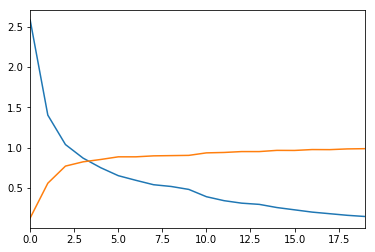

In [25]:
myfilter1 = np.random.normal(0,0.1,9*16).reshape(3,3,1,16)
myfilter2 = np.random.normal(0,0.1,9*16*18).reshape(3,3,16,18)
lossbn,accuracybn, parameters =train_CNN(temp,ytemp,myfilter1,myfilter2,fc1_neurons=20,num_class=10,alpha=0.5,iterations=20,pad=1)    
pd.Series(lossbn).plot()    
pd.Series(accuracybn).plot()
#batch norm can support very higher learning rate without divergence

In [26]:
loss,accuracy,_ = forward_propagate(temp_test,ytemp_test,parameters,fc1_neurons=20,num_class=10,pad=1)

In [27]:
loss,accuracy

(0.3986668663961918, 0.89)